In [12]:
#Import list
%load_ext autoreload
%autoreload 2
import warnings
import xlsxwriter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import Generative_model
from scipy import stats
import pandas as pd

import copy

#all pymc3 requirement
import pymc3 as pm
import theano.tensor as tt
import theano as th
import arviz as az


from pymc3 import Model, Normal, Slice, sample, Uniform, Binomial, HalfNormal
from pymc3.distributions import Interpolated



plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on PyMC3 v3.11.5


C:\Users\herma\AppData\Local\Temp\ipykernel_16596\2838497400.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [13]:

#Function to generate samples
#The function will add the results to the previous data set
# it will also add the total samples used per degree to a list called n_samples_per_degree
def generate_samples(mu,sigma,n_samples,n_samples_per_degree,degree,data_set):
    #create normal distribution
    normal_dist = stats.norm(loc = mu, scale=sigma)
    #sample data given amount of samples and distribution
    responses = np.random.binomial(n_samples,p=normal_dist.cdf(degree))
    #add responses to data set with +8 shift to account for degrees 
    data_set[degree+8] += responses
    #add amount of samples to n_samples_per_degree
    n_samples_per_degree[degree+8] += n_samples
    #return file
    return data_set,n_samples_per_degree
    



In [14]:

#this function calculates a cumulative densistiy function based on a given mean and std. This is used to convert the input variables.
def cumulative_normal(x, mean, sigma, s=np.sqrt(2)):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * tt.erf((x-mean)/(sigma*s))

In [15]:
#function to calculate entropy
def Calculate_entropy(lambda_list, theta):
    # Initialize lists
    # Probability of clockwise
    pcw = np.zeros(len(theta))
    # Probability of counter clockwise
    pccw = np.zeros(len(theta))  # Corrected to create a new zero array instead of sharing the reference

    # The dimensions of the input lambdas 
    dimensions_lambda = np.shape(lambda_list)
    
    # Initialization of empty list for the probability of a given lambda with a given theta being clockwise
    param_theta_cw = np.zeros((dimensions_lambda[0], len(theta)))
    param_theta_ccw = np.zeros((dimensions_lambda[0], len(theta)))  # Corrected to create a new zero array instead of sharing the reference

    # Go over all theta values
    for idx, theta_val in enumerate(theta):     
        Pcw_theta_lambda = []
        for lamb in lambda_list:
            # Given a specific lambda and degree (theta) clockwise probability
            Pcw_theta_lambda.append(stats.norm.cdf(theta_val, lamb[0], lamb[1]))
        # What is the total probability of clockwise for this degree (theta) 
        pcw[idx] = sum(Pcw_theta_lambda) / dimensions_lambda[0]
        # Probability counterclockwise
        pccw[idx] = 1 - pcw[idx]

    # Clip lists to avoid NaN
    pcw = np.clip(pcw, 1e-6, 1 - 1e-6)
    pccw = np.clip(pccw, 1e-6, 1 - 1e-6)

    # For each parameter pair
    for lamb_idx, lamb in enumerate(lambda_list):      # does this just calculate the mean? 
        # For each theta_val
        for idx, theta_val in enumerate(theta):
            # Find given probability
            p_cw = stats.norm.cdf(theta_val, lamb[0], lamb[1])
            p_ccw = 1 - p_cw
            #Calculate probability of a lambda given theta and direction (cw or ccw)
            param_theta_cw[lamb_idx, idx] = p_cw / pcw[idx]
            param_theta_ccw[lamb_idx, idx] = p_ccw / pccw[idx]

    # Calculate the log value of the probabilities
    # Clip is included to avoid NaN values
    log_param_theta_cw = np.log(np.clip(param_theta_cw, 1e-6, None))
    log_param_theta_ccw = np.log(np.clip(param_theta_ccw, 1e-6, None))

    # Calculate individual multiplications
    pre_sum_cw = log_param_theta_cw * param_theta_cw
    pre_sum_ccw = log_param_theta_ccw * param_theta_ccw
    # Calculate H (entropy component for cw and ccw)
    H_cw = np.sum(pre_sum_cw, axis=0)
    H_ccw = np.sum(pre_sum_ccw, axis=0)

    # Entropy calculation
    entropy = H_cw * pcw + H_ccw * pccw
    return entropy,(np.argmax(entropy)-8)

In [16]:
#ground truth
mu,sigma = 1,2
stimuli = np.arange(-8,9)
#set up the data:
#number of samples used per iteration
samples_per_degree = np.zeros(17)
data_set = np.zeros(17)
n_samples = 1
# for i in range(-8,9):
#     data_set,samples_per_degree = generate_samples(mu,sigma,n_samples=1,n_samples_per_degree=samples_per_degree,degree=i,data_set=data_set)


In [17]:
column_names = ["Entropy_x " + str(i) for i in range(-8,9)]
column_names.append("mu")
column_names.append("sigma")
column_names.append("stimulus_used")
column_names.append("lambda_list")
print(column_names)
data_frame_adaptive = pd.DataFrame(columns=column_names)

['Entropy_x -8', 'Entropy_x -7', 'Entropy_x -6', 'Entropy_x -5', 'Entropy_x -4', 'Entropy_x -3', 'Entropy_x -2', 'Entropy_x -1', 'Entropy_x 0', 'Entropy_x 1', 'Entropy_x 2', 'Entropy_x 3', 'Entropy_x 4', 'Entropy_x 5', 'Entropy_x 6', 'Entropy_x 7', 'Entropy_x 8', 'mu', 'sigma', 'stimulus_used', 'lambda_list']


In [18]:
#set up the model:
model_cdf = pm.Model()

with model_cdf:
    curve_mean = pm.Uniform('mn', lower=-8, upper =8)#pm.Normal("curve_mu",mu=0,sigma=5)
    curve_std =pm.Gamma("sd",alpha=3,beta=1)#pm.HalfNormal("curve_sigma",sigma=1.5)

    #calculate the cdfs of the means and std to fit onto the observations. 
    theta = pm.Deterministic('theta', cumulative_normal(stimuli,curve_mean,curve_std))
    Y_obs = pm.Binomial("Y_obs", n=samples_per_degree, p=theta, observed=data_set)
    model_trace = pm.sample(500, cores=4)  # Sampling from the model


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.


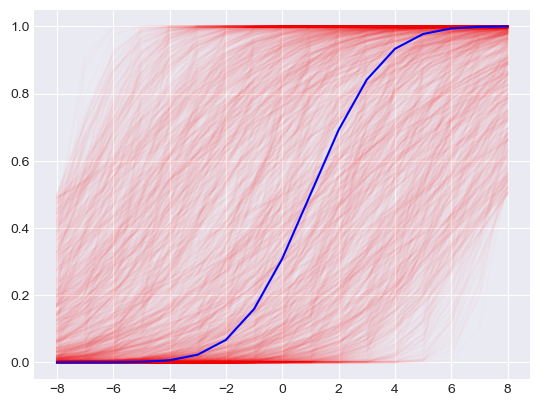

In [19]:
lamb_test = [(model_trace["mn"][i],model_trace["sd"][i]) for i in range(len(model_trace["sd"]))]   
for i in lamb_test:
    #plot the line with a 0.01 opacity to ensure viewability
    plt.plot(stimuli,stats.norm(loc = i[0], scale=i[1]).cdf(stimuli),alpha=0.01,color="r")
#plot ground truth
plt.plot(stimuli,stats.norm(loc = mu, scale=sigma).cdf(stimuli),color="b")
plt.show()

In [20]:
iteration_counter = 0
while iteration_counter <50:
    #check mean if criteria is met
    mu_mean = np.mean(model_trace["mn"])
    sd_mean = np.mean(model_trace["sd"])
    
    
    #check if the mu and sigma are within the hitting mark
    #extracting posterior samples
    lambda_list_adaptive = [(model_trace["mn"][i],model_trace["sd"][i]) for i in range(len(model_trace["sd"]))]

    entropy,proposed_stim = Calculate_entropy(lambda_list_adaptive,stimuli)
    iteration_counter += 1
    print(proposed_stim)
    data_set,samples_per_degree = generate_samples(mu,sigma,1,samples_per_degree,proposed_stim,data_set)
    print(data_set)
    print(samples_per_degree)
    
    with model_cdf:
        #fit the new data to the observations
        Y_obs = pm.Binomial("Y_obs"+str(iteration_counter), n=samples_per_degree, p=theta, observed=data_set)
        #trace the posterior
        model_trace = pm.sample(500, cores=4)   # Sampling from the model
    
    
    data_frame_adaptive.loc[iteration_counter] = entropy.tolist() + [mu_mean, sd_mean,proposed_stim]+[lambda_list_adaptive]

0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7191817934337068, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8886208510883022, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6530559776465377, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8788984121788304, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5621430371855513, but should be close to 0.8. 

3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6155098226044065, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 2. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8897462578146298, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8948030901553685, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 2. 2. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 3. 2. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8894667115175088, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7027266491395294, but should be close to 0.8. Try to increase the number of tuning steps.


2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 4. 2. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 71 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 4. 3. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 71 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 4. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 4. 4. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 5. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 4. 5. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 71 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 4. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 71 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8923845676084519, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 5. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 71 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 6. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 6. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 3. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 4. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 5. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 6. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 7. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 72 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 8. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 6. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 9. 7. 6. 0. 0. 0. 0. 0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1. 10.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 74 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1. 11.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.


1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 74 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  2. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 74 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  3. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 78 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  4. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 75 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 1. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  5. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 75 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 2. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  6. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 75 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 2. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  7. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 76 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 2. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  8. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 75 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 2. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  9. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 75 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 2. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. 10. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 74 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 3. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. 11. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 77 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 3. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. 12. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 76 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 4. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. 13. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 80 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 4. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. 14. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 76 seconds.


0
[0. 0. 0. 0. 0. 0. 0. 0. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 76 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 1. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  1. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 77 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 1. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  2. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 77 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 1. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  3. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 77 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 2. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  4. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 77 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 2. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  5. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 77 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 3. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  6. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 78 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 3. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  7. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 78 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 3. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  8. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 78 seconds.


-1
[0. 0. 0. 0. 0. 0. 0. 3. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  9. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 79 seconds.


-2
[0. 0. 0. 0. 0. 0. 0. 3. 5. 6. 4. 6. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  1.  9. 15. 12.  7.  6.  0.  0.  0.  0.  0.]


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 78 seconds.


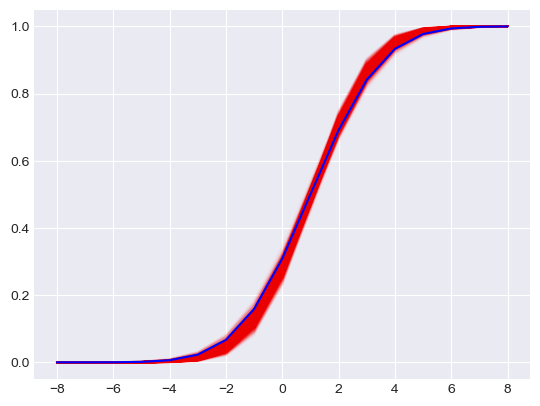

In [21]:

lamb_test = [(model_trace["mn"][i],model_trace["sd"][i]) for i in range(len(model_trace["sd"]))]   
for i in lamb_test:
    #plot the line with a 0.01 opacity to ensure viewability
    plt.plot(stimuli,stats.norm(loc = i[0], scale=i[1]).cdf(stimuli),alpha=0.01,color="r")
#plot ground truth
plt.plot(stimuli,stats.norm(loc = mu, scale=sigma).cdf(stimuli),color="b")
plt.show()

In [22]:
file_name = 'adaptive_samples2.csv'
data_frame_adaptive.to_csv(file_name)